<h1><center>ASHRAE - Great Energy Predictor III - EDA💡</center></h1>

# Libraries 📚

In [1]:
import numpy as np
import pandas as pd

import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Read data from interim files

In [2]:
weather_df = pd.read_pickle("../data/interim/weather_ts_df")
train_df = pd.read_pickle("../data/interim/train_ts_df")
building_df = pd.read_pickle("../data/interim/building_df")
weather_df.reset_index('site_id',inplace=True)

# Common functions

In [3]:
def percentage_null(df):
    return (df.isnull().sum()/df.count().max()*100).sort_values()

# Correlation plots

<AxesSubplot:xlabel='floor_count', ylabel='square_feet'>

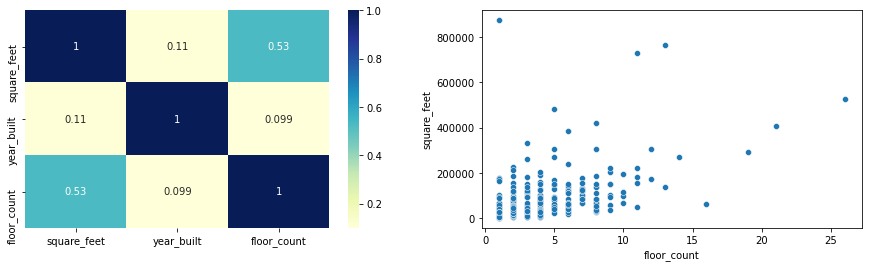

In [4]:
fig, axs = plt.subplots(1,2, figsize=(15, 4))
sns.heatmap(building_df.set_index(['building_id','site_id']).corr(),annot=True,cmap="YlGnBu",ax=axs[0])
sns.scatterplot(x='floor_count',y='square_feet',data=building_df,ax=axs[1])

In [5]:
train_df=train_df.reset_index().pivot(index=['timestamp','building_id'],columns='meter',values='meter_reading')
train_df=train_df.add_prefix("meter_")
train_df.columns = train_df.columns.tolist()
train_df=train_df.reset_index(level=1)

In [6]:
train_df.set_index('building_id',append=True,inplace=True)

<AxesSubplot:>

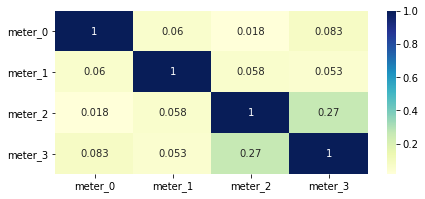

In [7]:
plt.figure(figsize=(7, 3))
sns.heatmap(train_df.corr(),annot=True,cmap="YlGnBu",yticklabels=True,xticklabels=True)

In [8]:
train_build_df = train_df.reset_index().merge(building_df)

In [9]:
train_build_df['year_built']=train_build_df['year_built']-1900

In [10]:
train_build_df['year_built'].fillna(0,inplace=True)

In [11]:
train_build_df['floor_count'].fillna(0,inplace=True)

In [12]:
train_build_df.set_index('timestamp',inplace=True)

In [13]:
train_build_df.rename(columns={'meter_0':'Electricity','meter_1':'ChilledWater','meter_2':'Steam','meter_3':'HotWater'},inplace=True)

<AxesSubplot:>

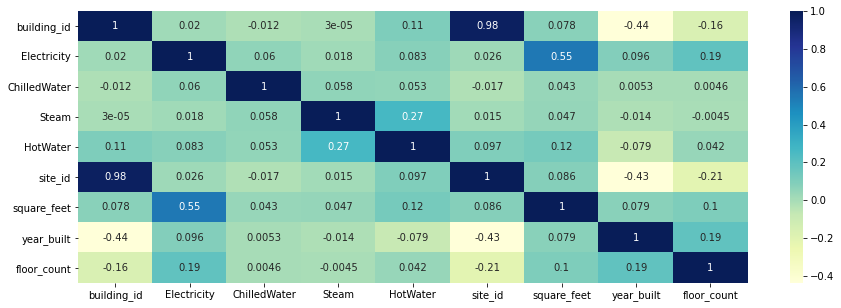

In [14]:
plt.figure(figsize=(15, 5))
sns.heatmap(train_build_df.corr(),annot=True,cmap="YlGnBu")

***Electricity has high +ve correlation with square-feet area of the building.***

# Correlation between meter_reading and weather data

In [15]:
weather_df.reset_index(inplace=True)

In [33]:
percentage_null(weather_df)

timestamp             0.0
site_id               0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

In [32]:
#weather_df['cloud_coverage']=weather_df['cloud_coverage'].fillna(weather_df.cloud_coverage.min())
weather_df.fillna(weather_df.min(),inplace=True)

In [34]:
train_weather_df = train_build_df.reset_index().merge(weather_df,how="left")

In [35]:
print("Percentage null values for the train_weather_df:\n{}".format(percentage_null(train_weather_df)))

Percentage null values for the train_weather_df:
timestamp              0.000000
floor_count            0.000000
year_built             0.000000
primary_use            0.000000
site_id                0.000000
square_feet            0.000000
building_id            0.000000
wind_direction         0.384856
air_temperature        0.384856
cloud_coverage         0.384856
dew_temperature        0.384856
precip_depth_1_hr      0.384856
sea_level_pressure     0.384856
wind_speed             0.384856
Electricity            2.687502
ChilledWater          66.254314
Steam                 78.144964
HotWater              89.801218
dtype: float64


In [22]:
#cols=weather_df.columns.difference(['timestamp'])
#train_weather_df[cols]=train_weather_df[cols].fillna(0)

In [124]:
agg_dict={'Electricity':'sum','ChilledWater':'sum','Steam':'sum','HotWater':'sum','floor_count':'sum',\
          'square_feet':'sum','year_built':'mean','air_temperature':'mean', 'cloud_coverage':'mean', \
          'dew_temperature':'mean','precip_depth_1_hr':'mean', 'sea_level_pressure':'mean',\
            'wind_direction':'mean','wind_speed':'mean'}
train_weather_grpsite_df=train_weather_df.groupby(['site_id','timestamp']).agg(agg_dict)

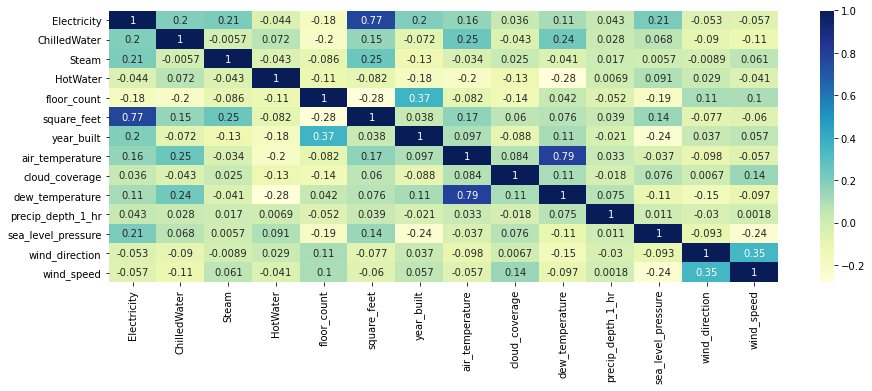

In [124]:
plt.figure(figsize=(15, 5))
sns.heatmap(train_weather_grpsite_df.corr(),annot=True,cmap="YlGnBu")
plt.savefig("../reports/figures/train_weather_grpsite_df.png")

***Total Electricity per site has +ve correlation with total-sqfeet and average sea_level_pressure<br>
Total chilled water per site has little +ve correlation with average air_temp & dew temp<br>
Total steam has little +ve correlation with total-sqfeet<br>
etc***

In [121]:
"""
train_weather_grpsite_df.to_pickle("../data/interim/train_weather_grpsite_df")
train_build_df.to_pickle("../data/interim/train_build_df")
train_weather_df.to_pickle("../data/interim/train_weather_df")
"""

<Figure size 7200x7200 with 0 Axes>

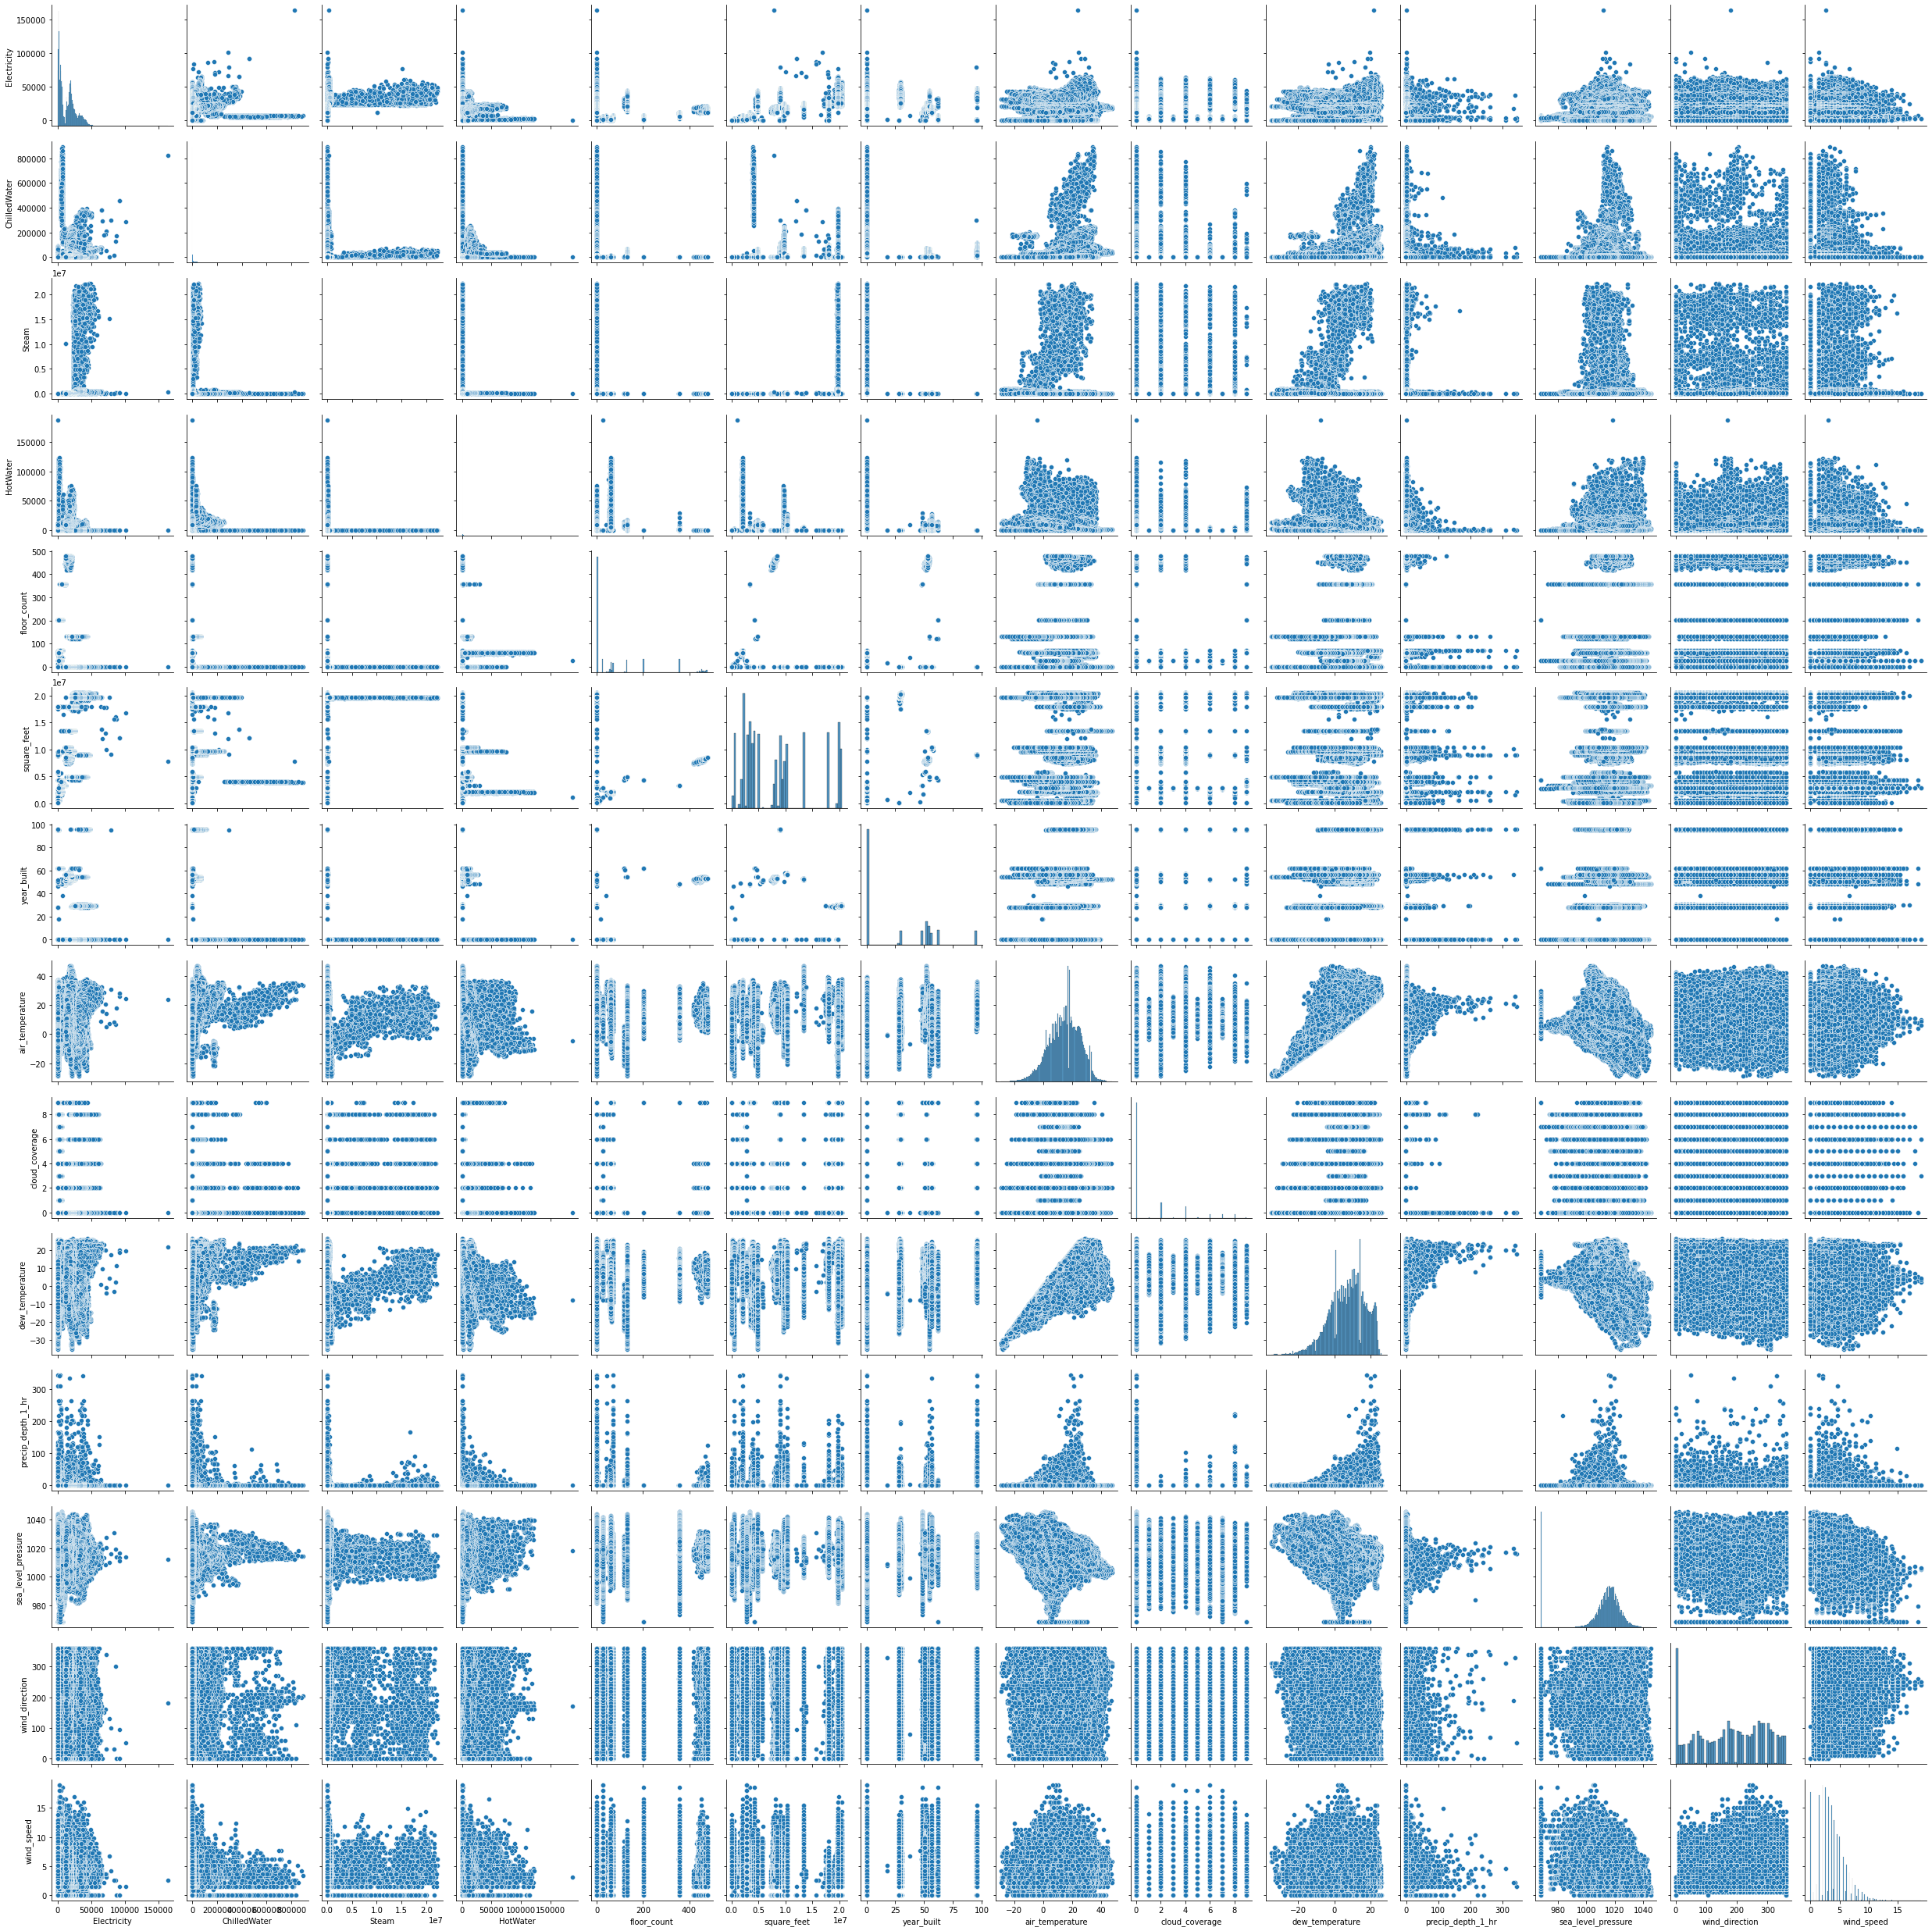

In [125]:
plt.figure(figsize=(100,100))
sns.pairplot(train_weather_grpsite_df)
plt.savefig("../reports/figures/train_weather_pairplot.png")